# 1 Loading the Dataset

In [4]:
import numpy as np
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
print(data.shape)

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
(1797, 64)


Extract instances showing "3" or "8", append a column of "1s" and create a vector of ground-truth labels where 1 corresponds to 3 and -1 to 8.

In [5]:
X = data[np.logical_or(target == 3, target == 8)]
y = target[np.logical_or(target == 3, target == 8)]

X = np.concatenate((X, np.ones([len(y),1])), axis = 1)

y[y==3] = 1
y[y==8] = -1

# 1.1 Classification with sklearn

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split

In [7]:
num_splits = 10
lambdas = [0.001,0.01,0.1,1,10,100,1000]
scores = np.zeros([len(lambdas), 2]) # save mean score and std for each lambda

for i, C in enumerate(lambdas):
    logistic = LogisticRegression(C = C)
    curr_scores = cross_val_score(logistic, X, y, cv = num_splits)
    scores[i,0] = np.average(curr_scores)
    scores[i,1] = np.std(curr_scores)

In [8]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format

In [9]:
display(pd.DataFrame(
        data = scores,
        index = lambdas,
        columns = ['mean','std'])
        .rename_axis('C', axis = 'columns'))

C,mean,std
0.0010,0.9688,0.0531
0.0100,0.9691,0.0464
0.1000,0.9860,0.0288
1.0000,0.9860,0.0288
10.0000,0.9803,0.0283
100.0000,0.9775,0.0304
"1,000.0000",0.9747,0.0341


The accuracy of the prediction varies only very slowly when modifying the regularization parameter. The best accuracy is obtained for $\lambda=0.1, 1, 10$, thus a very large range. In the following we will proceed using $\lambda=1$.

# 1.2 Optimization Methods

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [11]:
def predict(beta, X):
    # if X*beta > 0 --> y=1, if X*beta < 0 --> y=-1
    y = (X.dot(beta) >= 0) * 2 - 1
    return y

In [12]:
def zero_one_loss(y_prediction, y_truth):
    return np.sum(np.not_equal(y_prediction, y_truth))

In [13]:
def gradient(beta, X, y, lambda_ = 1):
    # distinguish the cases of one single / several training instances
    if np.isscalar(y):
        grad = beta / lambda_ - sigmoid(-X.dot(beta) * y) * y * X
    else:
        grad = beta / lambda_ - np.average((sigmoid(-X.dot(beta) * y) * y)[:,None] * X, axis = 0)
    return grad

In [14]:
def GD(X, y, beta, tau_0, gamma, m):
    for _ in range(m):
        tau = tau_0 / (1 + gamma * _)
        beta = beta - tau * gradient(beta, X, y)
    return beta

To sample single random instances, we do sampling without replacement since we want to avoid computing the gradient from the same instance repetitively. Instead, we want to use as much different samples as possible to compute the gradient.<br>
Only in the case of mini-batches, we do sampling with replacement since the training set is not large enough to sample 150 times a mini-batch witout replacing "old" samples.

In [15]:
from sklearn.utils import shuffle
def SGD(X, y, beta, tau_0, gamma, m):
    X, y = shuffle(X,y)
    for i in range(m):
        tau = tau_0 / (1 + gamma * i)
        beta = beta - tau * gradient(beta, X[i,:], y[i])
    return beta

In [16]:
def SG_minibatch(X, y, beta, tau_0, gamma, m, B = 1):
    # here we do not replace the samples since there would not be enough samples
    # to perform m=150 optimization steps for larger B
    for i in range(m):
        X, y = shuffle(X,y)
        tau = tau_0 / (1 + gamma * i)
        beta = beta - tau * gradient(beta, X[:B,:], y[:B])
    return beta

In [17]:
def SG_momentum(X, y, beta, tau_0, gamma, mu, m):
    X, y = shuffle(X,y)
    # initialize g
    g = np.zeros(len(beta))
    for i in range(m):
        tau = tau_0 / (1 + gamma * i)
        g = mu * g + (1 - mu) * gradient(beta, X[i,:], y[i])
        beta = beta - tau * g
    return beta

In [18]:
def ADAM(X, y, beta, m, tau=10**-4, mu1=0.9, mu2=0.999, eps=10**-8):
    X, y = shuffle(X,y)
    # initialize g, q
    g = np.zeros(len(beta))
    q = np.zeros(len(beta))
    for i in range(m):
        grad = gradient(beta, X[i,:], y[i])
        g = mu1 * g + (1 - mu1) * grad
        q = mu2 * q + (1 - mu2) * np.square(grad)
        beta = beta - tau / (np.sqrt(q) + eps) * g
    return beta

In [19]:
# so wie im Skript
def Newton_Raphson(X, y, beta, m, lambda_=0.001):# hier muss lambda kleiner gewählt werden, für lambda=1 divergiert das ganze
    N,D = X.shape
    for _ in range(m):
        z = X.dot(beta)
        y_tilde = y / sigmoid(-y * z)
        W = np.diag(lambda_ / N * sigmoid(z) * sigmoid(-z))
        inv = np.linalg.inv(1 / lambda_ * np.identity(D) + np.dot(X.T, np.dot(W, X)))
        beta = beta + np.dot(inv, np.dot(X.T, np.dot(W, y_tilde)) - beta / lambda_)
    return beta

In [20]:
# so wie auf dem Zettel
def Newton_Raphson1(X, y, beta, m, lambda_=0.001):
    N,D = X.shape
    for _ in range(m):
        z = X.dot(beta)
        y_tilde = y / sigmoid(-y * z)
        W = lambda_ / N * np.diag(sigmoid(z) * sigmoid(-z))
        inv = np.linalg.inv(np.identity(D) + np.dot(X.T, np.dot(W, X)))
        beta = np.dot(inv, np.dot(X.T, W)).dot(z + y_tilde)
    return beta

In [21]:
def dual_coordinate_ascent(X, y, m, lambda_=1):
    # initialization:
    N = X.shape[0]
    alpha = np.random.uniform(size=N)
    beta = lambda_ * np.average((alpha * y)[:,None] * X, axis=0)
    X, y = shuffle(X, y)
    for i in range(m):
        f_prime = y[i] * np.dot(X[i,:], beta) + np.log(alpha[i] / (1 - alpha[i]))
        f_2prime = lambda_ / N * np.dot(X[i,:], X[i,:].T) + 1 / (alpha[i] * (1 - alpha[i]))
        alpha_old = alpha[i].copy()
        alpha[i] = max(0, min(1, alpha[i] - f_prime / f_2prime))
        beta += lambda_ / N * y[i] * X[i,:] * (alpha[i] - alpha_old)
    return beta

In [22]:
def SAGD(X, y, beta_init, tau_0, gamma, m, lambda_ = 0.001):
    #init
    try:
        X, y = shuffle(X, y)
        N    = X.shape[0]
        beta = beta_init
        g_stored = np.zeros(N)
        g_vec    = np.zeros(N)
        for i in range(N):
            #print(sigmoid(-y[i] * np.dot(X[i,:],beta)))
            g_stored[i] = -y[i] * X[i, :] * sigmoid(-y[i] * np.dot(X[i,:],beta))
        g = np.average(g_stored)
        #iterate
        for i in range(m):
            g_vec[i] = -y[i] * X[i,:] * sigmoid(-y[i] * np.dot(X[i,:],beta))
            g     = g + 1. / N * (g_vec[i] - g_stored[i])
            tau_t = tau_0 / (1 + gamma * i)
            g_stored[i] = g_vec[i]
            beta  = beta * (1 - tau_t / lambda_) - tau_t * g 
        return beta
    except:
        raise NotImplementedError('Not yet implemented')

#### dual coordinate ascent

In [23]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 9)
beta = dual_coordinate_ascent(X_train, y_train, 150)

errors = zero_one_loss(predict(beta, X_test), y_test)
print(errors / len(y_test))

0.0277777777778


#### SAGD

In [24]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 0)
beta = np.zeros(65)
tau_0 = 0.001
gamma = 0.0001
beta = SAGD(X_train, y_train, beta, tau_0, gamma, 150)

errors = zero_one_loss(predict(beta, X_test), y_test)
print(errors / len(y_test))

NotImplementedError: Not yet implemented

#### GD

In [25]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 0)
beta = np.zeros(65)
beta = GD(X_train, y_train, beta, 0.001, 0.0001, 10)

errors = zero_one_loss(predict(beta, X_test), y_test)
print(errors / len(y_test))

0.0185185185185


#### Newton Raphson

In [26]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 0)
beta = np.zeros(65)
beta = Newton_Raphson(X_train, y_train, beta, 150)

errors = zero_one_loss(predict(beta, X_test), y_test)
print(errors / len(y_test))

0.0185185185185


In [27]:
X_test.shape

(108, 65)

#### SGD w/o replacement

In [28]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 0)
beta = np.zeros(65)
tau_0 = 0.001
gamma = 0.0001
beta = SGD(X_train, y_train, beta, tau_0, gamma, 150)

errors = zero_one_loss(predict(beta, X_test), y_test)
print(errors / len(y_test))

0.0185185185185


#### SGD with minibatch

In [29]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 0)
beta = np.zeros(65)
tau_0 = 0.001
gamma = 0.0001
beta = SG_minibatch(X_train, y_train, beta, tau_0, gamma, 150, B = 20)

errors = zero_one_loss(predict(beta, X_test), y_test)
print(errors / len(y_test))

0.0185185185185


#### ADAM

In [30]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 0)
beta = np.zeros(65)
tau_0 = 0.001
gamma = 0.0001
mu = 0.1
beta = ADAM(X_train, y_train, beta, 150)

errors = zero_one_loss(predict(beta, X_test), y_test)
print(errors / len(y_test))

0.0185185185185


# 1.3 Comparison

In [31]:
from sklearn.cross_validation import KFold
from operator import itemgetter
import itertools

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [32]:
optimizers = ['GD', 'SGD', 'SGD_mini', 'SGD_mom', 'ADAM', 'DualCA', 'NR']
#tbd: 'SAGD'

class LogisticRegression:
    def __init__(self, X, y, type_, beta_0):
        self.X = X
        self.y = y
        self.type = type_
        self.beta = beta_0
        
    def compare_parameters(self, tau_0_, mu_, gamma_, iter_ = 150, num_results_shown = None):
        if num_results_shown is None:
            num_results_shown = len(tau_0_)*len(mu_)*len(gamma_)
        if self.type in ['NR', 'GD']:
            iter_ = 10
        X_tr, X_test, y_tr, y_test = train_test_split (self.X, self.y, test_size = 0.3 ,random_state = 0)
        cross_val_results = []
        beta = self.beta
        for (tau_0, mu, gamma) in itertools.product(tau_0_, mu_, gamma_):
            kf = KFold(y_tr.shape[0], n_folds=10)
            errors = 0
            for train_idx, val_idx in kf:
                if self.type == 'SGD':
                    beta = SGD(X_tr[train_idx], y_tr[train_idx], beta, tau_0, gamma, iter_)
                elif self.type == 'GD':
                    beta = GD(X_tr[train_idx], y_tr[train_idx], beta, tau_0, gamma, iter_)
                elif self.type == 'SGD_mini':
                    #print('SGD minibatch running with B = ', B)
                    beta = SG_minibatch(X_tr[train_idx], y_tr[train_idx], beta, tau_0, gamma, iter_, B = 10)
                elif self.type == 'SGD_mom':
                    beta = SG_momentum(X_tr[train_idx], y_tr[train_idx], beta, tau_0, gamma, mu, iter_)
                elif self.type == 'ADAM':
                    #ADAM(X, y, beta, m, tau=10**-4, mu1=0.9, mu2=0.999, eps=10**-8):
                    beta = ADAM(X_tr[train_idx], y_tr[train_idx], beta, iter_)
                elif self.type == 'DualCA':
                    beta = dual_coordinate_ascent(X_tr[train_idx], y_tr[train_idx], iter_)
                elif self.type == 'NR':
                    beta = Newton_Raphson(X_tr[train_idx], y_tr[train_idx], beta, iter_)
                elif self.type == 'SAGD':
                    #beta = self.type(X_tr[train_idx], y_tr[train_idx], beta, tau_0, gamma, mu, iter_)
                    raise NotImplementedError('tbd')
                
                errors += zero_one_loss(predict(beta, X_tr[val_idx]), y_tr[val_idx])
                
            cross_val_results.append((tau_0, mu, gamma, errors))
            
        sort = np.array(sorted(cross_val_results, key = itemgetter(3)))
        print('\nUsing ' , self.type, ' optimizer.')
        print('Listing results starting with lowest error score: \n')
        display(pd.DataFrame(
            data = sort[:num_results_shown - 1, :3],
            index = sort[:num_results_shown - 1, -1],
            columns = ['tau_0','mu', 'gamma'])
            .rename_axis('errors', axis = 'columns'))
        
        return sort[0]
        #print(sorted(cross_val_results, key = itemgetter(3)))

In [33]:
tau, mu, gamma = [0.001, 0.01, 0.1], [0.1, 0.2, 0.5], [0.0001, 0.001, 0.01]
LR = LogisticRegression(X, y, 'SGD', np.zeros(65))
LR.compare_parameters(tau, mu, gamma)


Using  SGD  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
0.0000,0.0010,0.1000,0.0100
0.0000,0.0010,0.5000,0.0100
1.0000,0.0010,0.2000,0.0100
2.0000,0.0010,0.2000,0.0010
3.0000,0.0010,0.5000,0.0010
4.0000,0.0010,0.1000,0.0001
4.0000,0.0010,0.1000,0.0010
4.0000,0.0010,0.2000,0.0001
5.0000,0.0010,0.5000,0.0001
11.0000,0.0100,0.5000,0.0100


array([ 0.001,  0.1  ,  0.01 ,  0.   ])

#### listing the n best results of each optimizer

In [34]:
def list_n_best(X, y, n, opti_list, tau, mu, gamma):
    overview = np.empty([7], dtype=[('opt', 'U10'), ('tau', 'f4'), ('mu', 'f4'), ('gamma', 'f4')]) #for displaying the best parameters in the end
    for i, opt in enumerate(opti_list): 
        LR = LogisticRegression(X, y, opt, np.zeros(65))
        best = LR.compare_parameters(tau, mu, gamma, num_results_shown=n)
        overview['opt'][i] = opt
        overview['tau'][i] = best[0]
        overview['mu'][i] = best[1]
        overview['gamma'][i] = best[2]
    print("\n \n Overall best parameters: \n")
    display(pd.DataFrame(
            data = overview, index=overview['opt'],
            columns = ['tau','mu', 'gamma']).rename_axis('optimizer', axis = 'columns'))
    return overview

In [35]:
params = list_n_best(X, y, 10, optimizers, tau, mu, gamma)


Using  GD  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
3.0000,0.0010,0.1000,0.0100
3.0000,0.0010,0.2000,0.0001
3.0000,0.0010,0.2000,0.0010
3.0000,0.0010,0.2000,0.0100
3.0000,0.0010,0.5000,0.0001
3.0000,0.0010,0.5000,0.0010
3.0000,0.0010,0.5000,0.0100
3.0000,0.0100,0.1000,0.0001
3.0000,0.0100,0.1000,0.0010



Using  SGD  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
0.0000,0.0010,0.5000,0.0001
1.0000,0.0010,0.2000,0.0010
1.0000,0.0010,0.5000,0.0100
2.0000,0.0010,0.1000,0.0010
2.0000,0.0010,0.1000,0.0100
2.0000,0.0010,0.2000,0.0100
5.0000,0.0010,0.2000,0.0001
6.0000,0.0010,0.1000,0.0001
6.0000,0.0010,0.5000,0.0010



Using  SGD_mini  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
1.0000,0.0010,0.2000,0.0001
2.0000,0.0010,0.1000,0.0010
2.0000,0.0010,0.5000,0.0010
2.0000,0.0010,0.5000,0.0100
3.0000,0.0010,0.1000,0.0001
3.0000,0.0010,0.1000,0.0100
3.0000,0.0010,0.2000,0.0010
3.0000,0.0010,0.2000,0.0100
3.0000,0.0010,0.5000,0.0001



Using  SGD_mom  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
1.0000,0.0010,0.1000,0.0100
1.0000,0.0010,0.2000,0.0010
1.0000,0.0010,0.2000,0.0100
1.0000,0.0010,0.5000,0.0100
2.0000,0.0010,0.2000,0.0001
2.0000,0.0010,0.5000,0.0010
3.0000,0.0010,0.1000,0.0010
4.0000,0.0010,0.5000,0.0001
4.0000,0.0100,0.2000,0.0100



Using  ADAM  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
1.0000,0.0100,0.1000,0.0100
1.0000,0.1000,0.5000,0.0001
2.0000,0.0010,0.2000,0.0001
2.0000,0.0010,0.2000,0.0010
2.0000,0.0100,0.2000,0.0010
2.0000,0.0100,0.2000,0.0100
2.0000,0.0100,0.5000,0.0001
2.0000,0.1000,0.1000,0.0001
2.0000,0.1000,0.2000,0.0010



Using  DualCA  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
14.0000,0.0010,0.1000,0.0001
16.0000,0.0100,0.2000,0.0100
16.0000,0.0100,0.5000,0.0100
17.0000,0.1000,0.5000,0.0001
18.0000,0.1000,0.2000,0.0001
19.0000,0.0100,0.1000,0.0001
19.0000,0.0100,0.5000,0.0001
19.0000,0.1000,0.2000,0.0100
21.0000,0.0010,0.1000,0.0100



Using  NR  optimizer.
Listing results starting with lowest error score: 



errors,tau_0,mu,gamma
27.0000,0.0010,0.1000,0.0001
27.0000,0.0010,0.1000,0.0010
27.0000,0.0010,0.1000,0.0100
27.0000,0.0010,0.2000,0.0001
27.0000,0.0010,0.2000,0.0010
27.0000,0.0010,0.2000,0.0100
27.0000,0.0010,0.5000,0.0001
27.0000,0.0010,0.5000,0.0010
27.0000,0.0010,0.5000,0.0100



 
 Overall best parameters: 



optimizer,tau,mu,gamma
GD,0.0010,0.1000,0.0100
SGD,0.0010,0.5000,0.0001
SGD_mini,0.0010,0.2000,0.0001
SGD_mom,0.0010,0.1000,0.0100
ADAM,0.0100,0.1000,0.0100
DualCA,0.0010,0.1000,0.0001
NR,0.0010,0.1000,0.0001


 ## speed test

<IPython.core.display.Javascript object>


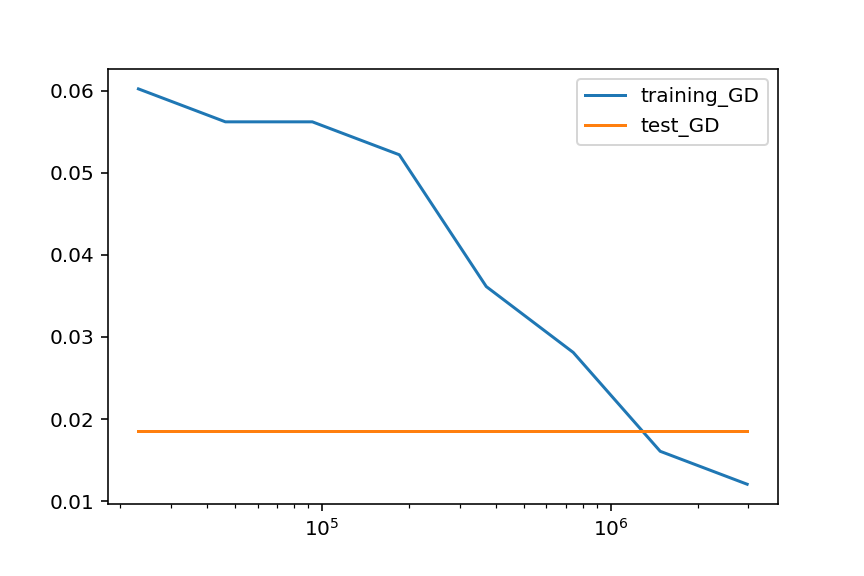

<IPython.core.display.Javascript object>


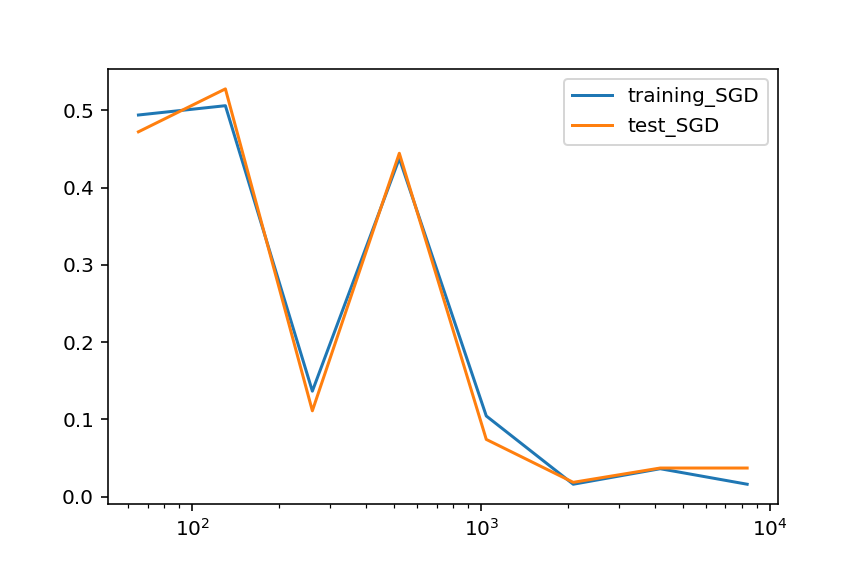

<IPython.core.display.Javascript object>


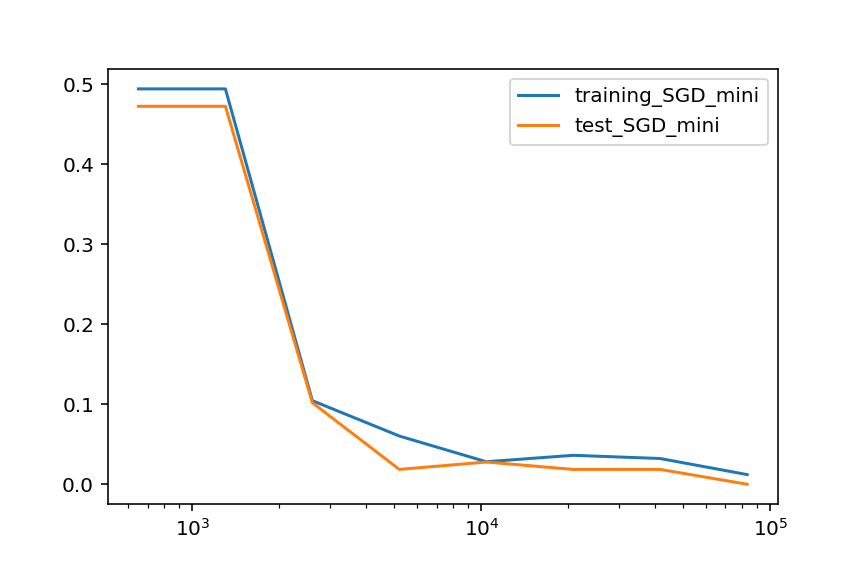

<IPython.core.display.Javascript object>


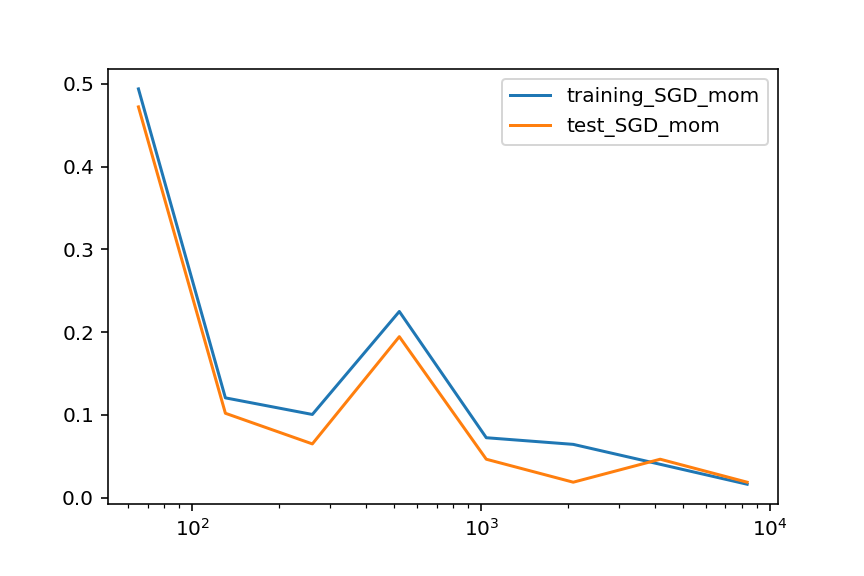

<IPython.core.display.Javascript object>


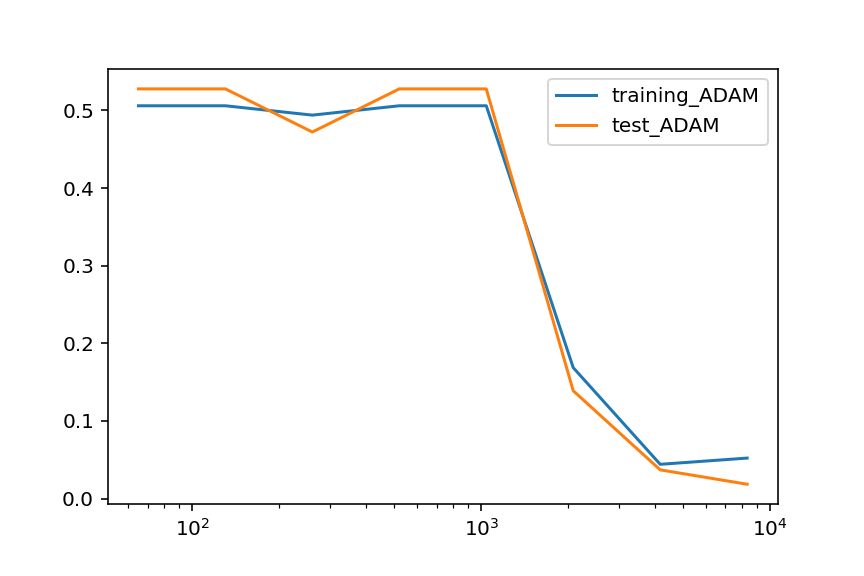

<IPython.core.display.Javascript object>


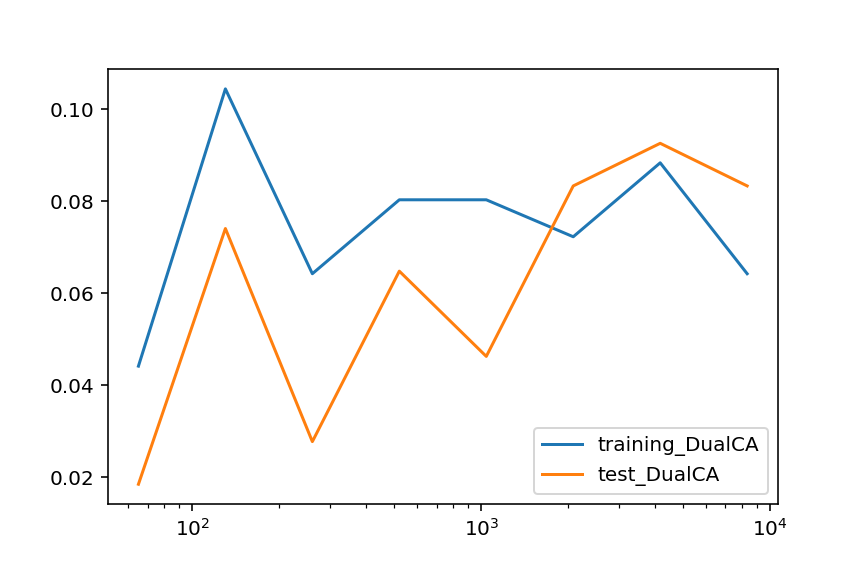

<IPython.core.display.Javascript object>


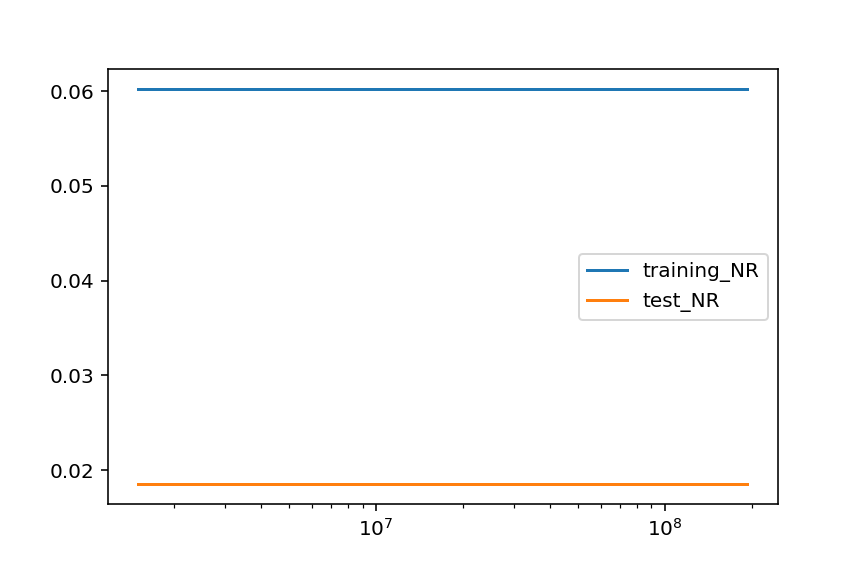

In [102]:
import matplotlib.pyplot as plt
%matplotlib notebook

data = np.empty(7, dtype=[  ('opt', 'U10'),
                            ('tau', 'f4'),
                            ('mu', 'f4'),
                            ('gamma', 'f4'),
                            ('compC', 'i8'),
                            ('iterdata', '(8, 4)f4')]) #use for iterations-training error-test error-T
#do iterations from 1 = 2^0 to 256=2^8 in steps of x2 as standard, ergo 9 steps. for NR and GD do
# iterations from 1 to 17 in steps of +2

for i, struct in enumerate(data): 
        struct['opt'] = params['opt'][i]
        struct['tau'] = params['tau'][i]
        struct['mu'] = params['mu'][i]
        struct['gamma'] = params['gamma'][i]
        if 0:#struct['opt'] in ['NR', 'GD']:
            struct['iterdata'] = [[1.,0.,0.,0.],
                                  [5.,0.,0.,0.],
                                  [9.,0.,0.,0.],
                                  [13.,0.,0.,0.],
                                  [17.,0.,0.,0.],
                                  [21.,0.,0.,0.],
                                  [25.,0.,0.,0.],
                                  [29.,0.,0.,0.]]
        else:
            struct['iterdata'] = [[1.,0.,0.,0.],
                                  [2.,0.,0.,0.],
                                  [4.,0.,0.,0.],
                                  [8.,0.,0.,0.],
                                  [16.,0.,0.,0.],
                                  [32.,0.,0.,0.],
                                  [64.,0.,0.,0.],
                                  [128.,0.,0.,0.]]
            
#insert computational complexiies
D = 65
N = 357
B = 10
data['compC'] = D
data['compC'][data['opt'] == 'GD'] = N*D
data['compC'][data['opt'] == 'SGD_mini'] = B*D
data['compC'][data['opt'] == 'NR'] = N*D**2

            
            
X_tr, X_test, y_tr, y_test = train_test_split (X, y, test_size = 0.3 ,random_state = 0)
for i, struct in enumerate(data): 
        beta = np.zeros(65)
        tau_0 = struct['tau']
        mu = struct['mu']
        gamma = struct['gamma']
        for j, iterdata in enumerate(struct['iterdata']):
            iter_ = int(iterdata[0])
            errors = 0
            if struct['opt'] == 'SGD':
                beta = SGD(X_tr, y_tr, beta, tau_0, gamma, iter_)
            elif struct['opt'] == 'GD':
                beta = GD(X_tr, y_tr, beta, tau_0, gamma, iter_)
            elif struct['opt'] == 'SGD_mini':
                #print('SGD minibatch running with B = ', B)
                beta = SG_minibatch(X_tr, y_tr, beta, tau_0, gamma, iter_, B = 10)
            elif struct['opt'] == 'SGD_mom':
                beta = SG_momentum(X_tr, y_tr, beta, tau_0, gamma, mu, iter_)
            elif struct['opt'] == 'ADAM':
                #ADAM(X, y, beta, m, tau=10**-4, mu1=0.9, mu2=0.999, eps=10**-8):
                beta = ADAM(X_tr, y_tr, beta, iter_)
            elif struct['opt'] == 'DualCA':
                beta = dual_coordinate_ascent(X_tr, y_tr, iter_)
            elif struct['opt'] == 'NR':
                beta = Newton_Raphson(X_tr, y_tr, beta, iter_)
            elif struct['opt'] == 'SAGD':
                #beta = self.type(X_tr, y_tr, beta, tau_0, gamma, mu, iter_)
                raise NotImplementedError('tbd')
            
            iterdata[1] = zero_one_loss(predict(beta, X_tr), y_tr)/len(y_tr)
            iterdata[2] = zero_one_loss(predict(beta, X_test), y_test)/len(y_test)
            iterdata[3] = iterdata[0]*struct['compC']
        #print(struct['iterdata'][:,3])
        #print(struct['iterdata'])
        plt.figure()
        plt.semilogx(struct['iterdata'][:,3],struct['iterdata'][:,1],label='training_'+struct['opt'])
        plt.semilogx(struct['iterdata'][:,3],struct['iterdata'][:,2],label='test_'+struct['opt'])
        plt.legend()
        #plt.plot(iterdata[3],iterdata[2],label='test')
    